<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/CSD2045/Generate_TB_ABR_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook allows you simulate physiological measurements for an infant case, with a focus on ABR threshold testing


The first section will prompt you for a case number. Run this section first to load information about your assigned patient to the colab work space. The other sections will only work without error once you have this step completed.

Once the information about your patient has been loaded you can run any of the remaining sections in any order until you are happy with your diagnostic evaluation. As you collect data, think about what information would be most valuable to add next and make the most difference clinically.

In [1]:
#@title This section loads the patient data for each case number and shows basic history information
import numpy as np
import pylab as pl
from scipy.interpolate import interp1d
import random
import os


file_path = 'cases.py'
url = 'https://www.dropbox.com/scl/fi/ra8ubq9m9nd03pl0kpnd8/cases.py?rlkey=v7ynfg1ssmfwn7bs3pa6fbr8v&dl=1'  # URL to download the file if it does not exist

# Check if the file exists
if not os.path.exists(file_path):
    # If the file does not exist, download it using wget
    !wget -q -O {file_path} {url}

from cases import dat




def getGorga1988Latency(L, f):
    # Ensure L and f are scalars
    if np.size(L) > 1 or np.size(f) > 1:
        raise ValueError("Level and frequency must be scalars in dB peSPL and kHz, respectively")

    Lref = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])
    aref = np.array([-0.230, -0.207, -0.219, -0.204, -0.177, -0.165, -0.157, -0.147, -0.139])
    bref = np.array([1.843, 1.727, 1.736, 1.652, 1.532, 1.462, 1.406, 1.356, 1.308])

    # Linear interpolation
    a = np.interp(L, Lref, aref)
    b = np.interp(L, Lref, bref)

    # Calculate tau
    tau = 10**(a * np.log10(f * 1e3) + b)

    return tau



def makeABR(a, l, t, f1=1, f3=1):
    a_ref = 0.33
    l_ref = 5.7

    # Wave V
    a1 = -9.372 * a / a_ref
    b1 = 6.659 * l / l_ref
    c1 = 1.038 * l / l_ref
    a2 = 7.301 * a / a_ref
    b2 = 6.885 * l / l_ref
    c2 = 0.901 * l / l_ref
    a3 = 3.745 * a / a_ref
    b3 = 6.096 * l / l_ref
    c3 = 0.8479 * l / l_ref

    # Wave II
    a8 = 0.08 * a * f1 / a_ref
    b8 = 3 * (l / l_ref)
    c8 = 0.35 * (l / l_ref)

    # Wave III
    a4 = 0.25 * a * f3 / a_ref
    b4 = 4.2 * (l / l_ref)
    c4 = 0.35 * (l / l_ref)

    # Wave I
    a5 = 0.7 * 0.1913 * a * f1 / a_ref
    b5 = 1.9 * l / l_ref
    c5 = 0.2 * l / l_ref
    a6 = -0.2 * 0.7 * a * f1 / a_ref
    b6 = 2.3 * l / l_ref
    c6 = 0.5 * l / l_ref
    a7 = 0.06 * 0.7 * a * f1 / a_ref
    b7 = 1.5 * l / l_ref
    c7 = 0.4 * l / l_ref

    # Make ABR
    x = (a1 * np.exp(-((t - b1) / c1) ** 2) +
         a2 * np.exp(-((t - b2) / c2) ** 2) +
         a3 * np.exp(-((t - b3) / c3) ** 2) +
         a4 * np.exp(-((t - b4) / c4) ** 2)  +
         a5 * np.exp(-((t - b5) / c5) ** 2) +
         a6 * np.exp(-((t - b6) / c6) ** 2) +
         a7 * np.exp(-((t - b7) / c7) ** 2) +
         a8 * np.exp(-((t - b8) / c8) ** 2))

    return x




def w5amp(L, f):
    y_start=0.05
    k=0.1
    L0=65
    f_ref = np.array([0.5, 1, 2, 4, 8])
    scale_ref = np.array([0.15, 0.2, 0.22, 0.27, 0.21])
    # Create cubic spline interpolation function
    cubic_spline = interp1d(f_ref, scale_ref, kind='cubic')
    scale = cubic_spline(f)
    y =  scale / (1 + np.exp(-k * (L - L0)))
    return y


def w1amp(L, f):
  # Anchors
  L_end = 90
  y_end = 0.2
  L_start = 35
  # Assume a growth rate k
  k = 0.05
  # Calculate C to satisfy the condition y=0.2 at x=90
  C = y_end / (np.exp(k * (L_end - L_start)) - 1)
  # Define the exponential growth function

  f_ref = np.array([0.5, 1, 2, 4, 8])
  scale_ref = np.array([0.1, 0.14, 0.18, 0.24, 0.21])
  # Create cubic spline interpolation function
  cubic_spline = interp1d(f_ref, scale_ref, kind='cubic')
  scale = cubic_spline(f) * 2.0
  return scale * C * (np.exp(k * (L - L_start)) - 1)


def getnHL(Lspl, f):
  # Use typical  approximate RETSPLs for ER3s to get nHL from peSPL
  RETSPL = np.array([20, 20, 25, 25])
  fref = np.array([0.5, 1, 2, 4])
  cubic_spline = interp1d(fref, RETSPL, kind='cubic')
  RETSPLf = cubic_spline(f)
  LnHL = Lspl - RETSPLf
  return LnHL


def nHL2eHL(LnHL, f, bc=False):
  # Using Ontario protocol with modification discussed in class
  f_ref = np.array([0.5, 1, 2, 4, 8])
  if bc:
    factor_ref = np.array([5, 5, -5, 0, 0])
  else:
    factor_ref = np.array([-15, -10, -5, 0, 0])
  cubic_spline = interp1d(f_ref, factor_ref, kind='cubic')
  factor = cubic_spline(f)
  return LnHL + factor

def eHL2nHL(LeHL, f, bc=False):
  # Using Ontario protocol with modification discussed in class
  f_ref = np.array([0.5, 1, 2, 4, 8])
  if bc:
    factor_ref = np.array([5, 5, -5, 0, 0])
  else:
    factor_ref = np.array([-15, -10, -5, 0, 0])
  cubic_spline = interp1d(f_ref, factor_ref, kind='cubic')
  factor = cubic_spline(f)
  return LeHL - factor



def getpeSPL(LnHL, f):
  # Use typical RETSPLs for ER3s to get nHL from peSPL
  RETSPL = np.array([25, 23, 28, 30])
  fref = np.array([0.5, 1, 2, 4])
  cubic_spline = interp1d(fref, RETSPL, kind='cubic')
  RETSPLf = cubic_spline(f)
  LpeSPL = LnHL + RETSPLf
  return LpeSPL



def getLinearEquivalentLoss(HL, f):
    """
    Calculate the gain needed to match loudness for hearing level of HL.
    Moore, B. C., & Glasberg, B. R. (1998). Use of a loudness model for
    hearing-aid fitting. I. Linear hearing aids.
    British Journal of Audiology, 32(5), 317-335.
    """
    f_ref = np.array([0.125, 0.25, 0.5, 0.75, 1.0,
                      1.5, 2.0, 3.0, 4.0, 5.0]) * 1e3  # Frequency in Hz
    int_ref = np.array([-11, -10, -8, -6, 0,
                        -1, 1, -1, 0, 1])  # Corresponding intensity references

    # Create a linear interpolation function
    interp = interp1d(f_ref, int_ref, kind='linear', fill_value='extrapolate')

    # Calculate intercept and intercept at 5k Hz
    int_actual = interp(f)
    int_5k = interp(5000)

    # Compute gain
    loss = 0.48 * HL + int_actual
    loss_5k = 0.48 * HL + int_5k

    # If frequency is greater than 5kHz, use the minimum of gain and gain at 5k
    if f > 5000:
        loss = min(loss, loss_5k)

    # Ensure gain is not negative
    loss = max(loss, 0)

    return loss


def adjustFsp(x):
    x = np.atleast_1d(x)
    b = 5
    a = (1 - 2.5) * np.exp(b)
    y = 2.5*x + (a * np.exp(-b*x))
    y[y < 1] = x[y < 1]
    return y



def isnumber(s):
    """Check if the input string s can represent an integer or a float."""
    try:
        float(s)  # Attempt to convert the string to a float
        return True
    except ValueError:
        return False



def noise(N, fs, sigma, psd=lambda f: 1):
    """
    Generate noise with a given Power Spectral Density (PSD).

    Parameters:
    - N: Number of samples
    - fs: Sampling rate in Hz
    - sigma: Noise standar deviation for scaling
    - psd: A function that defines the desired PSD, accepting frequency in Hz.

    Returns:
    - A noise signal in the time domain.
    """
    X_white = np.fft.rfft(np.random.randn(N))
    freqs = np.fft.rfftfreq(N, d=1/fs)  # Using actual sampling rate
    S = psd(freqs)  # Apply PSD function to actual frequencies
    S = sigma * S / np.sqrt(np.mean(S**2))  # Normalize PSD
    X_shaped = X_white * S
    return np.fft.irfft(X_shaped, n=N)


# Make a decorator to call the  noise generation once we have a PSD
def PSDGenerator(f):
    return lambda N, fs, sigma: noise(N, fs, sigma, f)

# For TB ABR assume noise is pink between f_low = 30 Hz and f_high = 1500 Hz
@PSDGenerator
def abr_noise(f):
    f_low = 30
    f_high = 1500
    eps = np.finfo(float).eps
    f[f < eps] = eps
    return np.where((f > f_low) & (f < f_high), 1 / f, 0)


# Prep lists to keep track of measurements that the user makes
earlist = []  # Keep track of which ear is measured
flist = []  # Keep track of sequence of stimuli presented
Llist = []  # Keep track of sequence of levels presented
Tlist = []  # Keep track of sequence of transducers (air or bone)
resplist = []  # Keep track of sequesces of corresponding responses
Fsplist = []  # Keep track of residual noise values
RNlist = []  # Keep track of Fsp values

earlistR = []  # Keep track of which ear is measured
flistR = []  # Keep track of sequence of stimuli presented
LlistR = []  # Keep track of sequence of levels presented
TlistR = []  # Keep track of sequence of transducers (air or bone)
resplistR = []  # Keep track of sequesces of corresponding responses
FsplistR = []  # Keep track of residual noise values
RNlistR = []  # Keep track of Fsp values




# Get case number
patnum = input('Enter the case number for your assigned patient:')
invalid = True
while invalid:
  # Define the set of valid values
  valid_values = 1 + np.arange(20)
  if isnumber(patnum):
    if int(patnum) in valid_values:
      invalid = False
    else:
      patnum = input(('\nInvalid! Case number should be 1 -- 20.'
                f' You entered {patnum}\n'
                'Enter the case number for your assigned patient:'))
  else:
    patnum = input(('\nInvalid! Case number should be 1 -- 20.'
                f' You entered {patnum}\n'
                'Enter the case number for your assigned patient:'))

patnum = int(patnum) - 1
info = dat['Cases'][patnum]

import textwrap
def print_wrapped_text(text, width=80):
    # Use the wrap function from textwrap to wrap text at the specified width
    wrapped_text = textwrap.wrap(text, width=width)

    # Print each line in the wrapped text
    for line in wrapped_text:
        print(line)

print_wrapped_text(f"This patient is a {info['age']}-week old {info['sex']} child referred to you from newborn hearing screening. {info['hx']}")


Enter the case number for your assigned patient:1
This patient is a 5-week old male child referred to you from newborn hearing
screening. Mother tested positive for CMV infection during pregnancy. No other
significant infections noted. Regular prenatal care received. Born at 37 weeks
via spontaneous vaginal delivery. Birth weight 2,500 grams. Apgar scores of 8
and 9 at 1 and 5 minutes, respectively. Both parents are in good health with no
history of significant genetic or infectious diseases. One older sibling,
female, healthy, with no history of CMV infection. Noted to have petechiae,
hepatosplenomegaly, and jaundice within the first 24 hours of life. Failed
newborn hearing screening in both ear. Referred to audiology for eval.


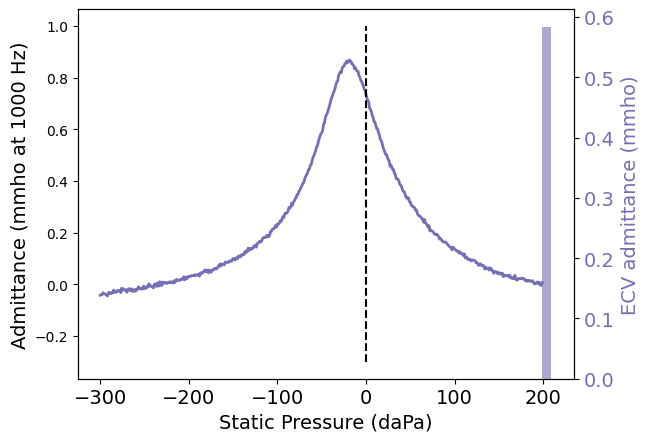

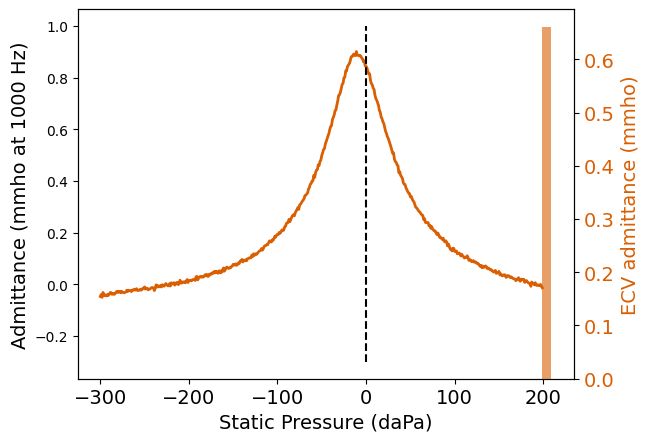

In [2]:
#@title Use this section the run 1000 Hz tympanometry in each ear of the patient

def vanhuyse_model(p, tpp=-10, G=0, Q=0.02):
    """
    Calculate the admittance based on the Vanhuyse model for tympanograms.

    Parameters:
    - p: Static air pressure in the ear canal (daPa).
    - tpp: Tympanometric peak pressure (daPa).
    - G: Conductance term.
    - Q: Quality factor related to the sharpness of the resonance peak.

    Returns:
    - Admittance (Y) as a complex number
    """
    # Convert to complex for calculation
    j = 1j

    # Calculate the admittance using the Vanhuyse model
    Y = 1 / (1 + j * (2 * Q) * (p - tpp)) + G / (1 + j * (2 * Q) * (p + tpp))
    return Y

def getTympanogram(p, tpp=-10, G=0, Q=0.02):
    Y = vanhuyse_model(p, tpp, G, Q)
    tymp = abs(Y) - abs(Y)[-1]
    N = p.shape[0]
    n = generate_gaussian_noise(N, sigma=0.005, T=N/4)
    # Add a hint of noise

    return tymp + n

import numpy as np

def generate_gaussian_noise(N, sigma=0.005, T=20):
    """
    Generate N samples of Gaussian stationary noise with an exponential autocorrelation function.

    Parameters:
    - N: The number of samples.
    - sigma: The standard deviation of the noise.
    - T: The characteristic scale for the exponential decay of the autocorrelation.

    Returns:
    - noise: N samples of the generated noise.
    """
    # Time steps, assuming unit sampling interval
    x = np.arange(N)

    # Autocorrelation function in time domain
    R_tau = sigma**2 * np.exp(-np.abs(x) / T)

    # Power Spectral Density (PSD) via Fourier Transform of the autocorrelation function
    PSD = np.fft.fft(R_tau, n=2*N-1)

    # Ensure PSD is real-valued due to numerical issues
    PSD = np.real(PSD)

    # Generate Gaussian white noise in frequency domain
    random_phase = np.exp(2j * np.pi * np.random.rand(2*N-1))
    sqrt_PSD = np.sqrt(PSD)
    noise_freq = sqrt_PSD * random_phase

    # Inverse Fourier Transform to get the noise in time domain
    noise = np.fft.ifft(noise_freq)[:N]

    # Ensure the noise is real
    # (it should be theoretically, but may not be due to numerical issues)
    noise = np.real(noise)

    # Scale the noise to have the desired standard deviation
    noise = noise * sigma / np.std(noise)

    return noise

lcol = [117./255, 112./255, 179./255]
rcol = [217./255, 95./255, 2./255]

# Generate the actual tymps for the left ear
pl.figure()
p = np.arange(-300, 200)
tpp = info['l']['tpp']
G = info['l']['G']
Q = info['l']['Q']
tymp = getTympanogram(p, tpp, G, Q)
ymax = np.max([np.max(tymp), 1])
ymin = np.min([np.min(tymp), -0.3])


pl.plot(p, tymp, color=lcol, linewidth=2)
pl.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linestyles='dashed')
pl.xlabel('Static Pressure (daPa)', fontsize=14)
pl.ylabel('Admittance (mmho at 1000 Hz)', fontsize=14)
pl.xticks(fontsize=14)

# Bar plot
ecy = (np.random.rand() - 0.5) * 0.2  + 0.6
ax2 = pl.gca().twinx()
ax2.set_ylabel('ECV admittance (mmho)', color=lcol, fontsize=14)
ax2.bar(np.max(p) + 5, ecy, color=lcol, alpha=0.6, width=10)
ax2.tick_params(axis='y', labelcolor=lcol)
pl.yticks(fontsize=14)

# Generate the actual tymps for the right ear
pl.figure()
p = np.arange(-300, 200)
tpp = info['r']['tpp']
G = info['r']['G']
Q = info['r']['Q']
tymp = getTympanogram(p, tpp, G, Q)
ymax = np.max([np.max(tymp), 1])
ymin = np.min([np.min(tymp), -0.3])


pl.plot(p, tymp, color=rcol, linewidth=2)
pl.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linestyles='dashed')
pl.xlabel('Static Pressure (daPa)', fontsize=14)
pl.ylabel('Admittance (mmho at 1000 Hz)', fontsize=14)
pl.xticks(fontsize=14)

# Bar plot
ecy = (np.random.rand() - 0.5) * 0.2  + 0.6
ax2 = pl.gca().twinx()
ax2.set_ylabel('ECV admittance (mmho)', color=rcol, fontsize=14)
ax2.bar(np.max(p) + 5, ecy, color=rcol, alpha=0.6, width=10)
ax2.tick_params(axis='y', labelcolor=rcol)
pl.yticks(fontsize=14)
pl.show()

Left (l) or Right(r)? Enter l or r:l
Enter the frequency you want to test in kHz (0.5, 1, 2, or 4):2
Air (a) or Bone(b)? Enter a or b:b
Enter the level you want to test in dB nHL:50


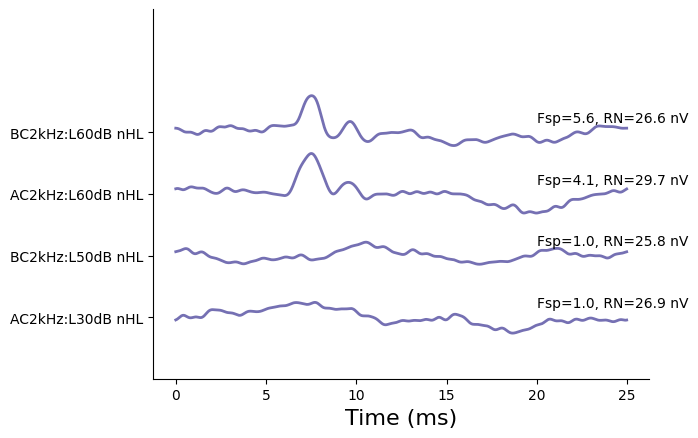

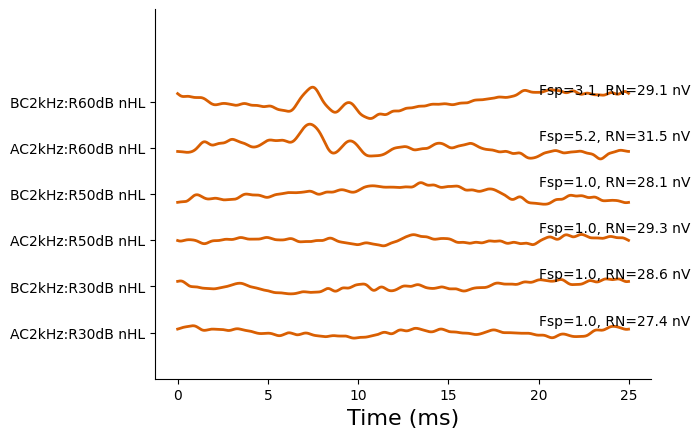

In [13]:
#@title This section generates the ABR data and plots results sorted by stimulus level (i.e., waterfall plots)

frequencies = [0.5, 1, 2, 4]
# Generate example
dur = 25e-3
fs = 48000
N = int(dur * fs)
t = np.arange(N) * 1e3 / fs  # milliseconds
sigma = 30e-3  # Microvolts
sigma_err = 10e-3

lcol = [117./255, 112./255, 179./255]
rcol = [217./255, 95./255, 2./255]



# Get testing parameters!
# Ear
ear = input('Left (l) or Right(r)? Enter l or r:')
invalid = True
while invalid:
  # Define the valid values in lowercase
  valid_values = ('l', 'r')
  if ear.lower() in valid_values:
    invalid = False
  else:
    ear = input(('\nInvalid! Ear should be l or r.'
                 f' You entered {ear}.\n'
                 'Left (l) or Right (r)?'))
ear = ear.lower()
earlist += [ear, ]


# Frequency
f = input('Enter the frequency you want to test in kHz (0.5, 1, 2, or 4):') # kHz
invalid = True
while invalid:
  # Define the set of valid values
  valid_values = (0.5, 1, 2, 4)
  if isnumber(f):
    if float(f) in valid_values:
      invalid = False
    else:
      f = input(('\nInvalid! Frequency should be 0.5, 1, 2, or 4.'
                f' You entered {f}\n'
                'Enter the frequency you want to test in kHz:')) # kHz
  else:
    f = input(('\nInvalid! Frequency should be 0.5, 1, 2, or 4.'
                f' You entered {f}\n'
                'Enter the frequency you want to test in kHz:')) # kHz

f = float(f)

if ear == 'l':
  flist += [f, ]
else:
  flistR += [f, ]

# Air or bone
transducer = input('Air (a) or Bone(b)? Enter a or b:')
invalid = True
while invalid:
  # Define the valid values in lowercase
  valid_values = ('a', 'b')
  if transducer.lower() in valid_values:
    invalid = False
  else:
    transducer = input(('\nInvalid! Transducer should a or b.'
                        f' You entered {transducer}.\n'
                        'Air (a) or Bone(b)?'))
transducer = transducer.lower()

if ear == 'l':
  Tlist += [transducer, ]
else:
  TlistR += [transducer, ]



# Level in dB nHL
LnHL = input('Enter the level you want to test in dB nHL:')
invalid = True
while invalid:
  # Define the set of valid values
  if isnumber(LnHL):
    if float(LnHL) >= -10 and float(LnHL) <= 110:
      invalid = False
    else:
      LnHL = input(('\nSorry! Level should be between -10 and 110 dB nHL\n'
                f' You entered {LnHL}\n'
                'Enter the level you want to test in dB nHL:')) # dB nHL
  else:
    LnHL = input(('\nSorry! Level should be between -10 and 110 dB nHL\n'
                f' You entered {LnHL}\n'
                'Enter the level you want to test in dB nHL:')) # dB nHL
LnHL = float(LnHL)

if ear == 'l':
  Llist += [LnHL, ]
else:
  LlistR += [LnHL, ]




LpeSPL = getpeSPL(LnHL, f)
LeHL = nHL2eHL(LnHL, f)



offset = 0.3

# Generate noise
RN = (np.random.rand() - 0.5) * sigma_err + sigma
if ear == 'l':
  RNlist += [RN,]
else:
  RNlistR += [RN,]

n = abr_noise(N, fs, RN)  # microvolts

thresh = info[ear][f][transducer]

if LeHL < thresh:
  A5 = 0
  A1 = 0
  lat = getGorga1988Latency(LpeSPL, f)  # Latency doesn't matter here
else:
  if info['type'] == 'SNHL':
    loss = getLinearEquivalentLoss(thresh, f)
    Leff = LpeSPL - loss
    lat = getGorga1988Latency(LpeSPL, f)  # Latency doesn't change for SNHL
    A5 = w5amp(Leff, f)
    A1 = w1amp(Leff, f)
  else:
    if transducer == 'b':
      loss = getLinearEquivalentLoss(thresh, f)
      Leff = LpeSPL - loss
      lat = getGorga1988Latency(LpeSPL, f)  # Latency doesn't change for SNHL
      A5 = w5amp(Leff, f)
      A1 = w1amp(Leff, f)
    else:  # AC when there is a conductive component
      thresh_b = info[ear][f]['b']
      abg = thresh - thresh_b
      loss = getLinearEquivalentLoss(thresh_b, f)
      Leff = LpeSPL - loss - abg

A3 = (2.0 * A5 + A1) / 3.0
x = makeABR(A5, lat, t, f1=A1, f3=A3) + n  # Microvolts

if ear == 'l':
  resplist += [x, ]
else:
  resplistR += [x, ]

Fsp = adjustFsp( (x ** 2.).mean()  / (n ** 2.).mean() )

if ear == 'l':
  Fsplist += [Fsp,]
else:
  FsplistR += [Fsp,]

# LEFT EAR FIRST
pl.figure()
offset = 0.3
offset_start = 0
labels = []
for kf, freq in enumerate(frequencies):
  # Extract the indices where flist matches freq
  matching_indices = [i for i, f in enumerate(flist) if f == freq]

  if len(matching_indices) > 0:

    # Use the indices to extract the corresponding elements from Llist and Tlist
    Llist_subset = [Llist[i] for i in matching_indices]
    Tlist_subset = [Tlist[i] for i in matching_indices]
    resplist_subset = [resplist[i] for i in matching_indices]
    RNlist_subset = [RNlist[i] for i in matching_indices]
    Fsplist_subset = [Fsplist[i] for i in matching_indices]

    # Combine Llist_subset and Tlist_subset into a list of pairs
    combined_list = list(zip(Llist_subset,
                             Tlist_subset,
                             resplist_subset,
                             RNlist_subset,
                             Fsplist_subset))

    # Sort the combined list by the first element of each pair (i.e., by L)
    sorted_combined_list = sorted(combined_list, key=lambda x: x[0])

    # Unzip the pairs back into two lists
    Llist_sorted, Tlist_sorted, resplist_sorted, RNlist_sorted, Fsplist_sorted = zip(*sorted_combined_list)

    # Convert the tuples back to lists (if you need list type)
    Llist_sorted = list(Llist_sorted)
    Tlist_sorted = list(Tlist_sorted)
    resplist_sorted = list(resplist_sorted)
    RNlist_sorted = list(RNlist_sorted)
    Fsplist_sorted = list(Fsplist_sorted)

    # Now plot
    n_levels = len(Llist_sorted)
    for kL, lev in enumerate(Llist_sorted):
      xcurr = resplist_sorted[kL]
      Fspcurr = Fsplist_sorted[kL]
      RNcurr = RNlist_sorted[kL]
      pl.plot(t, offset_start + xcurr + kL*offset, linewidth=2, color=lcol)
      pl.text(20, offset_start + kL * offset + 0.05,
              f'Fsp={Fspcurr[0]:.1f}, RN={RNcurr * 1e3:.1f} nV')
      T = Tlist_sorted[kL].upper()
      labels += [f'{T}C{freq}kHz:L{lev:0.0f}dB nHL',]
    # Hide the top and right spines
    pl.gca().spines['top'].set_visible(False)
    pl.gca().spines['right'].set_visible(False)
    pl.xlabel('Time (ms)', fontsize=16)
    nticks = len(labels)
    pl.yticks(ticks=np.arange(0, nticks) * offset,
              labels=labels, fontsize=10)
    pl.ylim([-offset, (nticks + 1) * offset])
    offset_start += n_levels * offset
pl.show()


# RIGHT EAR NEXT
pl.figure()
offset = 0.3
offset_start = 0
labels = []
for kf, freq in enumerate(frequencies):
  # Extract the indices where flist matches freq
  matching_indices = [i for i, f in enumerate(flistR) if f == freq]

  if len(matching_indices) > 0:

    # Use the indices to extract the corresponding elements from Llist and Tlist
    Llist_subset = [LlistR[i] for i in matching_indices]
    Tlist_subset = [TlistR[i] for i in matching_indices]
    resplist_subset = [resplistR[i] for i in matching_indices]
    RNlist_subset = [RNlistR[i] for i in matching_indices]
    Fsplist_subset = [FsplistR[i] for i in matching_indices]

    # Combine Llist_subset and Tlist_subset into a list of pairs
    combined_list = list(zip(Llist_subset,
                             Tlist_subset,
                             resplist_subset,
                             RNlist_subset,
                             Fsplist_subset))

    # Sort the combined list by the first element of each pair (i.e., by L)
    sorted_combined_list = sorted(combined_list, key=lambda x: x[0])

    # Unzip the pairs back into two lists
    Llist_sorted, Tlist_sorted, resplist_sorted, RNlist_sorted, Fsplist_sorted = zip(*sorted_combined_list)

    # Convert the tuples back to lists (if you need list type)
    Llist_sorted = list(Llist_sorted)
    Tlist_sorted = list(Tlist_sorted)
    resplist_sorted = list(resplist_sorted)
    RNlist_sorted = list(RNlist_sorted)
    Fsplist_sorted = list(Fsplist_sorted)

    # Now plot
    n_levels = len(Llist_sorted)
    for kL, lev in enumerate(Llist_sorted):
      xcurr = resplist_sorted[kL]
      Fspcurr = Fsplist_sorted[kL]
      RNcurr = RNlist_sorted[kL]
      pl.plot(t, offset_start + xcurr + kL*offset, linewidth=2, color=rcol)
      pl.text(20, offset_start + kL * offset + 0.05,
              f'Fsp={Fspcurr[0]:.1f}, RN={RNcurr * 1e3:.1f} nV')
      T = Tlist_sorted[kL].upper()
      labels += [f'{T}C{freq}kHz:R{lev:0.0f}dB nHL',]
    # Hide the top and right spines
    pl.gca().spines['top'].set_visible(False)
    pl.gca().spines['right'].set_visible(False)
    pl.xlabel('Time (ms)', fontsize=16)
    nticks = len(labels)
    pl.yticks(ticks=np.arange(0, nticks) * offset,
              labels=labels, fontsize=10)
    pl.ylim([-offset, (nticks + 1) * offset])

    offset_start += n_levels * offset
pl.show()


Which ear would you like measure DPs in? Enter l for lefr or r for right:r


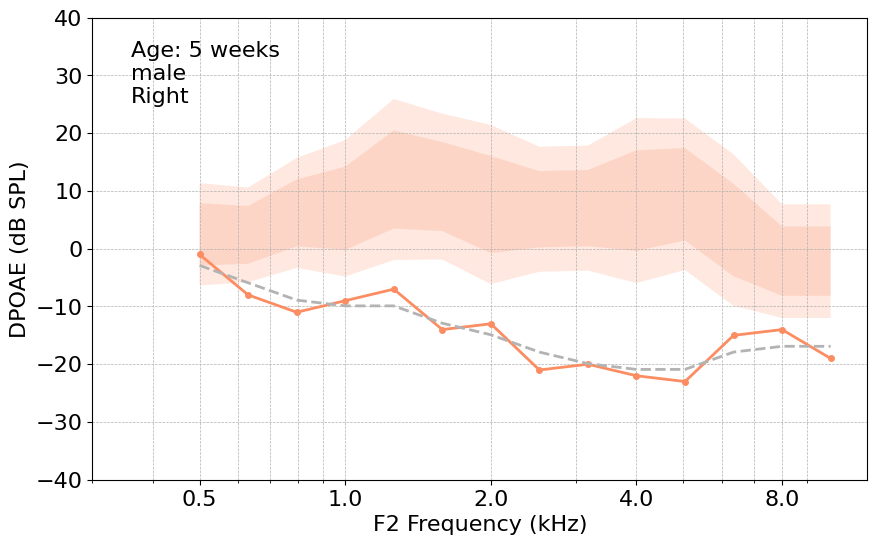

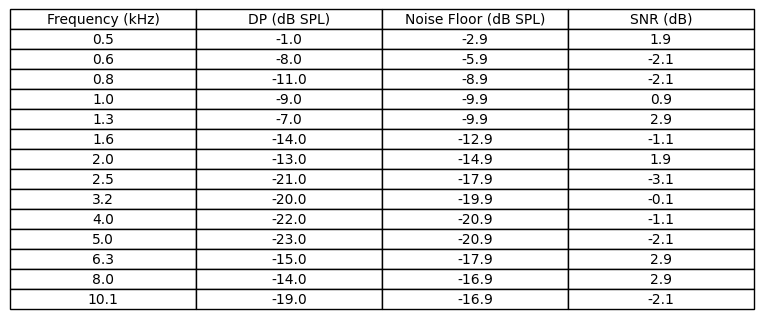

In [3]:
#@title This section generates the DPOAE case data and shows results!
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.interpolate import CubicSpline


def getDPdrop(x):
  # Generate a DP drop that asymptotes to -50 for large losses, but drops to -25
  # for input of 40. This way OAE becomes absent for losses > about 40-50 dB.
  x0 = 40
  A = -50
  k = 0.15  # Seems to give reasonable steepness
  drop = A / (1 + np.exp(-k * (x - x0)))
  return drop

def getDPdrop_ABG(x):
  # Generate a DP drop that asymptotes to -30 for large losses, but drops to -15
  # for input of 15. This way OAE is absent for conductive losses > about 30 dB.
  x0 = 30
  A = -30
  k = 0.15  # Seems to give reasonable steepness
  drop = A / (1 + np.exp(-k * (x - x0)))
  return drop


# Frequencies
frequencies = [0.5, 1, 2, 4]  # For behavior and ABR
fdp = 0.5 * 2 ** np.arange(0, 13/3 + 1/3, 1/3)  # For DPs
fplot = 0.5 * 2 ** np.arange(0, 4 + 1)


m_male = np.array([2.5, 2.4, 6.2, 7, 10.9, 8.6, 4.4, 2.5, 2.7, 4, 5.1, -1.1, -5.4, -5.4])
m_female = np.array([5.2, 8.4, 9.4, 11.7, 11.2, 11.7, 7.7, 5, 3.3, 8, 11.2, 7, -5.4, -5.4])
sigma = np.array([5.4, 5, 5.8, 7.2, 8.5, 7.7, 8.4, 6.6, 6.6, 8.7, 8, 8, 6, 6])
dev_shift = np.array([0, 0, 0, 0, 1.5, 3, 4.5, 6, 6, 6, 6, 6, 4.5, 4.5])

m_noise = np.array([-9, -12, -15, -16, -16, -19, -21, -24, -26, -27, -27, -24, -23, -23])

n = m_noise

# Generate a new case
sex_string = info['sex']
if sex_string == 'male':
  sex = False
else:
  sex = True


age = info['age']  # Years
age_string = f"Age: {age} weeks"

# --------------------
# Get ear for testing
# --------------------

# Get testing parameters!
# Ear
eardp = input('Which ear would you like measure DPs in? Enter l for lefr or r for right:')
invalid = True
while invalid:
  # Define the valid values in lowercase
  valid_values = ('l', 'r')
  if eardp.lower() in valid_values:
    invalid = False
  else:
    eardp = input(('\nInvalid! Ear should be l or r.'
                 f' You entered {ear}.\n'
                 'Left (l) or Right (r)?'))

if eardp == 'l':
  ear_string = f"Left"
  eardp = True
else:
  ear_string = f"Right"
  eardp = False


# Set whether norms are plotted or not
plotnorms = True



# Get behavioral loss and make a predcted DP drop curve
loss_BC = np.array([info['l'][fbeh]['b'] for fbeh in frequencies])
loss_AC = np.array([info['l'][fbeh]['a'] for fbeh in frequencies])
ABG = loss_AC - loss_BC


loss_spline = CubicSpline(np.array(frequencies),
                          getDPdrop(loss_BC) + getDPdrop_ABG(ABG))

shift = loss_spline(fdp)


# ----------------------------------------------
# Apply shift to normal example and plot
# ----------------------------------------------

if sex:
  m = m_female
else:
  m = m_male

# Number of elements
n_elements = len(m)

# Create a covariance matrix that implies high correlation between elements
# For simplicity, set off-diagonal values to be some fraction of diagonal
correlation_factor = 0.95  # This should be less than 1
covariance_matrix = np.outer(sigma, sigma) * correlation_factor
# Set the diagonal to the variance of each element
np.fill_diagonal(covariance_matrix, sigma**2)

# Generate a random draw from a multivariate normal distribution
np.random.seed(23)
random_draw = np.random.multivariate_normal(m, covariance_matrix)
dp = random_draw + shift

# Generate noise floor
sigma_n = np.ones(14) * 6
covariance_matrix_n = np.outer(sigma_n, sigma_n) * correlation_factor
n = np.random.multivariate_normal(n, covariance_matrix_n)

while n[0] < -15:  # Avoid unrealistically low noise floor
  n = np.random.multivariate_normal(n, covariance_matrix_n)

# Find indices where dp is less than n
indices = dp < n

# For each index where dp is less than n, generate a random value in the specified range
for index in np.where(indices)[0]:
    lower_bound = n[index] - 5  # 5 below the value in n
    upper_bound = n[index] + 3  # 2 above the value in n (exclusive), hence +3
    dp[index] = np.random.randint(lower_bound, upper_bound)


# ----------------------------------------------
# Plot DPOAEs
# ----------------------------------------------

col = [102/255, 194/255, 165/255] if eardp else [252/255, 141/255, 98/255]
marker = 'o'

plt.figure(figsize=(10, 6))

if plotnorms:
    m = m_female if sex else m_male
    if age <= 3:
      m = m + dev_shift

    if age > 3 and age <= 18:
      m = m + ((18.0 - age)/18.0) * dev_shift

    lo = m - sigma
    hi = m + sigma
    plt.fill_between(fdp, lo, hi, color=(*col, 0.2), edgecolor='none')

    lo = m - 1.64 * sigma
    hi = m + 1.64 * sigma
    plt.fill_between(fdp, lo, hi, color=(*col, 0.2), edgecolor='none')

plt.plot(fdp, dp, '-', marker=marker, color=col, linewidth=2, markersize=4)

# Noise plot
coln = [0.7, 0.7, 0.7]
plt.plot(fdp, n, '--', color=coln, linewidth=2)

# Axis and labels
plt.xscale('log')
tick_labels = [f"{x:.1f}" for x in fplot]  # Convert fplot values to string labels
plt.xticks(fplot, tick_labels)  # Set custom tick labels
plt.xlabel('F2 Frequency (kHz)', fontsize=16)
plt.ylabel('DPOAE (dB SPL)', fontsize=16)
plt.xlim([0.3, 12])
plt.ylim([-40, 40])
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.text(0.05, 0.95, age_string, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=16)
plt.text(0.05, 0.9, sex_string, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=16)
plt.text(0.05, 0.85, ear_string, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=16)

plt.show
plt.show()

# ----------------------------------------------
# Tabulate results too!
# ----------------------------------------------

# Calculate SNR
snr = dp - n

# Format the data with one decimal place
# Here we use numpy vectorize function to apply formatting to each element
format_func = np.vectorize(lambda x: f"{x:.1f}")
f_formatted = format_func(fdp)
dp_formatted = format_func(dp)
n_formatted = format_func(n)
snr_formatted = format_func(snr)

# Combine the formatted data for table display
table_data = np.column_stack((f_formatted, dp_formatted, n_formatted, snr_formatted))
column_labels = ["Frequency (kHz)", "DP (dB SPL)", "Noise Floor (dB SPL)", "SNR (dB)"]

# Create a figure and a plot
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Add the table
table = ax.table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='center')

# Adjust the table properties for aesthetics
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the scale for better spacing

plt.show()